# ニューラルネット実装/実験

## 目次

1.データセット(MNIST)の取得<br>
2.単層のニューロン層の定義<br>
3.多層ニューラルネットの定義<br>
4.基準とする3層モデル<br>
5.L2正則化/ドロップアウト/Adamによる学習効果<br>
6.ノイズによる学習効果/性能の変化<br>
7.ニューロン数の変更/多層化<br>
8.最適刺激の計算

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
import h5py

%matplotlib inline

## 1. MNISTデータの取得

In [3]:
# なぜか二回実行するとうまくいく
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
# 訓練データ
X_train = mnist.train.images.T
Y_train = mnist.train.labels.T

#テストデータ
X_test = mnist.test.images.T
Y_test = mnist.test.labels.T

In [5]:
X_test.shape,X_train.shape

((784, 10000), (784, 55000))

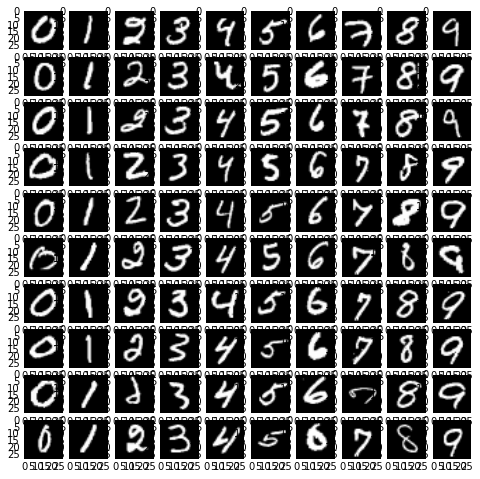

In [213]:
plt.figure(figsize=(8,8))
for i in range(10):
    for j in range(10):
        index = indices[i,j]
        plt.subplot(10,10,(i+1)+10*j)
        train_X_show = (X_train[:,Y_train[i,:].reshape(-1)==1][:,j]*255).reshape(28, 28).astype("uint8")
        plt.imshow(train_X_show, cmap='gray')
        #print( int( sum( np.array(range(10))*Y_train[:,index] ) ) )

## 2. 単層のニューロン層の定義

### 2.1. Backward Propagation の式
\begin{eqnarray}
&dZ^{(i)}& =   g'(Z^{(i)})^T dX_{out}^{(i)}\hspace{5mm} 
    \left(\substack{
        \forall i \in \text{\{training sample indices\}}\\
        g:Z^{(i)}\mapsto X_{out}\text{ ...activation function}  
   }\right)
    \\
&dX_{in}& = \frac{\partial E }{\partial X_{in}} = W^T dZ \hspace{5mm} 
\\
&dW& = \frac{\partial E }{\partial W} = \frac{1}{m} dZ {X_{in}}^T  - \frac{\lambda}{m}W
    \\
&db& = \frac{\partial E }{\partial b} = \frac{1}{m} \sum_{i = 1}^{m} dZ^{(i)}
\end{eqnarray}


※$dY$は横ベクトルであり、$\lambda$はL2正則化のパラメータ
\begin{eqnarray}
dY &:=& 
    \left[
        \frac{\partial E}{\partial Y_1} \hspace{3mm}
        \frac{\partial E}{\partial Y_2} \hspace{3mm}
        \cdots \hspace{3mm}
        \frac{\partial E}{\partial Y_m} \hspace{3mm}
    \right]
\\\\
X_{out}& = &
    \left[
        \begin{array}{rr}
            | \hspace{4mm} & | \hspace{4mm} &  & | \hspace{12mm}\\
            X_{out}^{(1)} & X_{out}^{(2)} & \cdots & X_{out}^{(
                \scriptsize\text{batch size}
                \normalsize )}  \\
            | \hspace{4mm} & | \hspace{4mm} &  & | \hspace{12mm}\\
        \end{array}
    \right] \hspace{5mm}
\\\\
X_{in}& = &
    \left[
        \begin{array}{rr}
            | \hspace{4mm} & | \hspace{4mm} &  & | \hspace{12mm}\\
            X_{in}^{(1)} & X_{in}^{(2)} & \cdots & X_{in}^{(
                \scriptsize\text{batch size}
                \normalsize )}  \\
            | \hspace{4mm} & | \hspace{4mm} &  & | \hspace{12mm}\\
        \end{array}
    \right] \hspace{5mm}
\\\\
Z& = &
    \left[
        \begin{array}{rr}
            | \hspace{4mm} & | \hspace{4mm} &  & | \hspace{12mm}\\
            Z^{(1)} & Z^{(2)} & \cdots & Z^{(
                \scriptsize\text{batch size}
                \normalsize )}  \\
            | \hspace{4mm} & | \hspace{4mm} &  & | \hspace{12mm}\\
        \end{array}
    \right] \hspace{5mm}
\\\\
g'(Z^{(i)})& = &
    \left[
        \begin{array}{rr}
            \frac{\partial g_1}{\partial Z^{(i)}_1} & \frac{\partial g_1}{\partial Z^{(i)}_2} & \cdots & \frac{\partial g_1}{\partial Z^{(i)}_m}\\
            \frac{\partial g_2}{\partial Z^{(i)}_1} & \ddots &  & \vdots \\
            \vdots &  & \ddots & \vdots \\
            \frac{\partial g_m}{\partial Z^{(i)}_1} & \cdots & \cdots & \frac{\partial g_m}{\partial Z^{(i)}_m}\
        \end{array}
    \right] \hspace{5mm}
\end{eqnarray}

### 2.2. そのほか仕様
・確率的最急降下法を採用.<br>
・Adagradを採用.<br>
・その他、前提条件は以下の通り.<br>
 
 |Hyper Parameter|value|
 |:--|:--:|
 |learning rate| 0.01|
 |epoch|10000|
 |mini-batch size|16|
 
<br>
・He-初期化を採用.<br>
　$W \sim N(0,{\sigma_W}^2)$<br>
　$\sigma_W = \sqrt{\frac{2}{\text{dim-input}}}$
<br>
<br>
 ・L2-正則化が可能.<br> 
  　$\min\limits_{W} \left[ E(W, X_\text{train},Y_\text{train})+\frac{\lambda}{2}||W||_2^2 \right] $
<br>
<br>
・Adamによる、最適化が可能.<br>
　更新式は、
<br> 
　$\begin{cases}
v_{dW} = \beta_1 v_{dW} + (1 - \beta_1) dW \\
v^{\ corrected}_{dW} = \frac{v_{dW}}{1 - (\beta_1)^t} \\
s_{dW} = \beta_2 s_{dW} + (1 - \beta_2) (dW)^2 \\
s^{\ corrected}_{dW} = \frac{s_{dW}}{1 - (\beta_2)^t} \\
\end{cases}$<br>
$ \ \ \  W = W - \alpha \frac{v^{\ corrected}_{dW}}{\sqrt{s^{\ corrected}_{dW}\ \ \ \ } + \varepsilon \ }$
<br>
　ただし、 $t$ は、Adamの更新回数. <br>
　$v$, $s$ は、$dW$, $(dW)$ の要素別の指数的減衰平均であり、$dW:=\frac{\partial E(W,X_\text{train},Y_\text{train})}{\partial W}$.
 
 

In [7]:
class Layer():
    
    # 持ってる変数/関数一覧 （可読性のため）
    dim_out = None
    dim_in = None
    n_sample = None
    activation = None
    W = None
    b = None
    Z = None
    X_in = None
    X_out = None 
    Drop_X_out = None
    dW = None
    db = None
    dZ = None
    dX_in = None
    dX_out = None
    expMean_dW = 0
    expMean_db = 0
    expMean_dW_squared = 0
    expMean_db_squared = 0
    sum_dW_squared = 0
    sum_db_squared = 0
    beta1_powered_by_epoch = 1
    beta2_powered_by_epoch = 1
    get_Activate = None
    get_dActivate_dZ = None
 
    def __init__(self, dim_in, dim_out, sigma_W, activation='relu'):
        # 重みの初期化
        self.W = np.random.randn(dim_out,dim_in) * sigma_W
        self.b = np.zeros(shape=(dim_out,1))
        self.dim_in = dim_in
        self.dim_out = dim_out
        self.activation = activation
        self.expMean_dW = np.zeros_like(self.W)
        self.expMean_db = np.zeros_like(self.b)
        self.expMean_dW_squared = np.zeros_like(self.W)
        self.expMean_db_squared = np.zeros_like(self.b)
        self.sum_dW_squared = np.zeros_like(self.W)
        self.sum_db_squared = np.zeros_like(self.b)
        self.beta1_powered_by_epoch = 1
        self.beta2_powered_by_epoch = 1

    def get_Activate(self):#活性化関数の定義
        if self.activation=='relu':
            return np.vectorize(lambda x:max(x,0))(self.Z) 
        elif self.activation=='softmax':
            return np.exp(-self.Z)/np.exp(-self.Z).sum(axis=0)
        else:
            raise("Invalid Activcation")    

    def get_dActivate_dZ(self):#活性化関数の定義
        if self.activation=='relu':
            return np.vectorize(lambda x:1. if x>0 else 0.)(self.Z)
        else:
            raise("Invalid Activcation")    
            
    def forward_prop(self, X_in, keep_prob=1):
        self.keep_prob = keep_prob
        self.X_in = X_in
        self.n_sample = self.X_in.shape[1]
        self.Z = self.W.dot(X_in) + self.b
        # Dropoutの有無で分岐
        if self.keep_prob<1:
            self.Drop_X_out = np.random.rand(self.dim_out, self.n_sample)
            self.X_out = self.get_Activate() * self.Drop_X_out / self.keep_prob
        else:
            self.X_out = self.get_Activate()
        
        
    def backward_prop(self, dX_out):
        # Dropoutの有無で分岐
        if self.keep_prob<1:
            self.dX_out = dX_out * self.Drop_X_out / self.keep_prob
        else:
            self.dX_out = dX_out
        # 活性化関数によって、逆伝播の式が異なる
        if self.activation=="relu":
            self.dZ = dX_out*self.get_dActivate_dZ().reshape(self.Z.shape)
        elif self.activation=="softmax":
            Y = self.X_out
            get_dYi_dZi = lambda Yi:np.diag(Yi)-np.dot(Yi.reshape(-1,1), Yi.reshape(-1,1).T)
            dY_dZ = [get_dYi_dZi(Y[:,i]) for i in range(self.n_sample)]
            self.dZ = np.array([dY_dZ[i].dot(dX_out[:,i]) for i in range(self.n_sample)]).T
        
        self.dX_in = self.W.T.dot(self.dZ).reshape(self.X_in.shape)
 
    def update_weight(self, learning_rate=0.01, reg_lambda=0, beta1=0, beta2=0, Ada_grad=False):
        self.dW = (1./self.n_sample)*self.dZ.dot(self.X_in.T).reshape(self.W.shape) + (reg_lambda/self.n_sample)*self.W
        self.db = (1./self.n_sample)*self.dZ.sum(axis=1).reshape(self.b.shape) + (reg_lambda/self.n_sample)*self.b
        # Adam (Adaptive Moment Estimation) しないとき
        if beta1==0 and beta2==0 and Ada_grad==False:
            self.W = self.W - learning_rate*self.dW
            self.b = self.b - learning_rate*self.db
        else:
            self.expMean_dW = (1-beta1)*self.dW + beta1*self.expMean_dW
            self.expMean_db = (1-beta1)*self.db + beta1*self.expMean_db
            self.expMean_dW_squared = (1-beta2)*(self.dW**2) + beta2*self.expMean_dW_squared
            self.expMean_db_squared = (1-beta2)*(self.db**2) + beta2*self.expMean_db_squared
            self.sum_dW_squared = self.sum_dW_squared + self.dW**2
            self.sum_db_squared = self.sum_db_squared + self.db**2
            self.beta1_powered_by_epoch = beta1*self.beta1_powered_by_epoch
            self.beta2_powered_by_epoch = beta2*self.beta2_powered_by_epoch
            # 勾配の発散によって、expMeanが減少するので、ZeroDevisiopnEroorになるくさい
            if Ada_grad==False:
                correction_dW = 1  /  ( np.sqrt(self.expMean_dW_squared/(1-self.beta2_powered_by_epoch)) + 1e-8 )
                correction_db = 1  /  ( np.sqrt(self.expMean_db_squared/(1-self.beta2_powered_by_epoch)) + 1e-8 )
                self.W = self.W - learning_rate*(self.expMean_dW/(1-self.beta1_powered_by_epoch)) * correction_dW
                self.b = self.b - learning_rate*(self.expMean_db/(1-self.beta1_powered_by_epoch)) * correction_db
            else:
                self.W = self.W - learning_rate*self.dW/(np.sqrt(self.sum_dW_squared) + 1e-8)
                self.b = self.b - learning_rate*self.db/(np.sqrt(self.sum_db_squared) + 1e-8)
                

## 3. 多層ニューラルネットの定義

In [8]:
class NeuralNetwork():

    # 持ってる変数/関数一覧 （可読性のため）
    n_Layers = None
    Layer_dims = []
    Layers = []
    
    def __init__(self, Layer_dims):
        self.Layers = []
        self.Layer_dims = Layer_dims
        self.n_Layers = len(Layer_dims)-1
        for i in range(self.n_Layers):
            dim_out = Layer_dims[i+1]
            dim_in = Layer_dims[i]
            # sigma_W=np.sqrt(2/dim_in)...He initialization
            if i != (self.n_Layers-1):
                new_Layer = Layer(dim_in, dim_out, sigma_W=np.sqrt(2/dim_in) , activation='relu')
            elif i == (self.n_Layers-1):
                new_Layer = Layer(dim_in, dim_out, sigma_W=np.sqrt(2/dim_in) , activation='softmax')
            self.Layers.append(new_Layer)
            
    def forward_prop(self, X, keep_prob=1):
        X_in = X
        for i in range(self.n_Layers):
            self.Layers[i].forward_prop(X_in, keep_prob= keep_prob if i!=self.n_Layers-1 else 1)
            X_in = self.Layers[i].X_out
        
    def compute_dY_pred(self, Y, Y_pred):
        dY_pred = np.divide(Y, Y_pred) 
        return dY_pred

    def backward_prop(self, dY_pred):
        dX_out = dY_pred
        for i in reversed(range(self.n_Layers)):
            self.Layers[i].backward_prop(dX_out)
            dX_out = self.Layers[i].dX_in

    def update_weight(self, learning_rate, reg_lambda=0, beta1=0, beta2=0, Ada_grad=False):
        for i in range(self.n_Layers):
            self.Layers[i].update_weight(learning_rate, reg_lambda=reg_lambda, beta1=beta1, beta2=beta2,  Ada_grad=Ada_grad)
    
    def train_once(self, X, Y, learning_rate=0.01, reg_lambda=0, beta1=0, beta2=0, Ada_grad=False, keep_prob=1):
        self.forward_prop(X, keep_prob=keep_prob)
        Y_pred = self.Layers[self.n_Layers-1].X_out
        dY_pred = self.compute_dY_pred(Y, Y_pred)
        self.backward_prop(dY_pred)
        self.update_weight(learning_rate=0.01, reg_lambda=reg_lambda, beta1=beta1, beta2=beta2, Ada_grad=Ada_grad)
    
    def predict(self, X):
        self.forward_prop(X)
        Y_pred =self.Layers[self.n_Layers-1].X_out
        return Y_pred
    
    def compute_cost(self,X, Y):
        n_sample = Y.shape[1]
        Y_pred = self.predict(X)
        cost = -(1/n_sample)*(Y*np.log(Y_pred)).sum(axis=(0,1))
        return cost


In [9]:
# 学習のラッパー
def train_NN(NN, X_train=X_train, Y_train=Y_train, X_test=X_test, Y_test=Y_test
             , n_epoch=10000, batch_size=16, learning_rate=0.01, reg_lambda=0
             , beta1=0, beta2=0, Ada_grad=False, keep_prob=1, print_interval=1000, get_cost=False):
    print("#epoch","cost","","train_Accuracy","test_Accuracy",sep="\t")
    n_train_sample = X_train.shape[1]
    train_cost_list = []
    test_cost_list = []
    for i in range(n_epoch):
        index_batch = np.random.randint(n_train_sample//batch_size)
        X_mini_batch = X_train[:,index_batch*batch_size:(index_batch+1)*batch_size]
        Y_mini_batch = Y_train[:,index_batch*batch_size:(index_batch+1)*batch_size]
        NN.train_once(X_mini_batch,Y_mini_batch,learning_rate, reg_lambda, beta1, beta2, Ada_grad, keep_prob)
        if i%print_interval==(print_interval-1):
            print("  "+str(i+1)
                  ,round(NN.compute_cost(X_train,Y_train)*100000)/100000,""
                  ,1-np.abs(Y_train - Y_train*np.eye(10)[[NN.predict(X_train).argmax(axis=0)]].T).sum(axis=0).mean(),""
                  ,1-np.abs(Y_test  - Y_test *np.eye(10)[[NN.predict(X_test).argmax(axis=0)]].T).sum(axis=0).mean()
                  ,sep="\t"
                 )
        if get_cost and i%100==0:
            train_cost_list.append(1-np.abs(Y_train - Y_train*np.eye(10)[[NN.predict(X_train).argmax(axis=0)]].T).sum(axis=0).mean())
            test_cost_list.append(1-np.abs(Y_test  - Y_test *np.eye(10)[[NN.predict(X_test).argmax(axis=0)]].T).sum(axis=0).mean())
    if get_cost==False:
        return NN
    else:
        return NN,{"train_cost_list": train_cost_list, "test_cost_list": test_cost_list}

In [10]:
#NN_models = {}

In [10]:
def dump_NN_models(NN_models):
    import pickle
    with open(b"models\NN_models.pickle","wb") as f:
        pickle.dump(NN_models,f)

def load_NN_models():
    import pickle
    with open(b"models\NN_models.pickle","rb") as f:
        return pickle.load(f)

In [11]:
NN_models = load_NN_models()

## 4. 基準とする3層のモデル

### 3層、バッチ、Adagrad
<br>
※気分でノード数を 784-128-32-10 にした. <br>
　メモリの関係上、２のべき乗が良いと、どこかで聞いた気がする.<br>
　 (←気のせいもしれない)

In [95]:
np.random.seed(1)
Layer_dims = [784,128, 32, 10]
NN = NeuralNetwork(Layer_dims)
# 初期コスト
NN.compute_cost(X_train,Y_train)

2.3643404986986387

In [96]:
arg_dict = {
     "learning_rate":0.01
    ,"Ada_grad":True
    }

In [97]:
NN = train_NN(NN,**arg_dict)

#epoch	cost		train_Accuracy	test_Accuracy
  1000	0.24272		0.929690909091		0.9316
  2000	0.20554		0.941890909091		0.9401
  3000	0.17707		0.949345454545		0.9469
  4000	0.16999		0.950545454545		0.9502
  5000	0.14955		0.957218181818		0.9528
  6000	0.14386		0.9574		0.9532
  7000	0.1313		0.961690909091		0.9573
  8000	0.12585		0.964145454545		0.9593
  9000	0.11825		0.966181818182		0.9604
  10000	0.11508		0.966763636364		0.9613


In [98]:
NN_models["NN_3L_Adagrad"] = NN
dump_NN_models(NN_models)

## 5. L2正則化/ドロップアウト/Ada_Grad,Adamによる学習効果

### 5.1. L2正則化の学習効果

In [109]:
for reg_lambda in [0.1, 0.3, 0.7, 2.0]:
    print("lambda =",reg_lambda)
    arg_dict = {
         "reg_lambda":reg_lambda
        ,"Ada_grad":True
        ,"learning_rate":0.01
        }
    np.random.seed(1)
    Layer_dims = [784, 128, 32, 10]
    NN = NeuralNetwork(Layer_dims)
    NN = train_NN(NN,**arg_dict)
    NN_models["NN_3L_Adagrad_L2_"+str(reg_lambda)] = NN
    
dump_NN_models(NN_models)

lambda = 0.1
#epoch	cost		train_Accuracy	test_Accuracy
  1000	0.3011		0.915036363636		0.9223
  2000	0.27405		0.925654545455		0.9252
  3000	0.25489		0.930890909091		0.9342
  4000	0.24546		0.932563636364		0.9314
  5000	0.23588		0.9354		0.9367
  6000	0.23194		0.935163636364		0.9376
  7000	0.22352		0.939109090909		0.9395
  8000	0.21928		0.940709090909		0.9414
  9000	0.21614		0.941181818182		0.9412
  10000	0.2134		0.941963636364		0.9415
lambda = 0.3
#epoch	cost		train_Accuracy	test_Accuracy
  1000	0.39795		0.894872727273		0.9044
  2000	0.37851		0.904381818182		0.9055
  3000	0.37143		0.906836363636		0.9138
  4000	0.36221		0.906945454545		0.912
  5000	0.36015		0.908854545455		0.9106
  6000	0.35685		0.907363636364		0.9114
  7000	0.3506		0.910472727273		0.9118
  8000	0.34796		0.912381818182		0.9148
  9000	0.35067		0.911127272727		0.9141
  10000	0.34646		0.911981818182		0.9144
lambda = 0.7
#epoch	cost		train_Accuracy	test_Accuracy
  1000	0.56148		0.869654545455		0.8805
  2000	0.54339		0.87636363

### 5.1. L2正則化、訓練データを500個に限定

In [110]:
for reg_lambda in [0, 0.1, 0.3, 0.7, 2.0]:
    print("lambda =",reg_lambda)
    arg_dict = {
         "X_train":X_train[:,:500]
        ,"Y_train":Y_train[:,:500]
        ,"reg_lambda":reg_lambda
        ,"Ada_grad":True
        ,"learning_rate":0.01
        }
    np.random.seed(1)
    Layer_dims = [784, 128, 32, 10]
    NN = NeuralNetwork(Layer_dims)
    NN = train_NN(NN,**arg_dict)
    NN_models["NN_3L_Adagrad_L2_"+str(reg_lambda)+"_500_training"] = NN
    
dump_NN_models(NN_models)

lambda = 0
#epoch	cost		train_Accuracy	test_Accuracy
  1000	0.00832		1.0		0.8533
  2000	0.00454		0.998		0.8504
  3000	0.00321		0.998		0.8533
  4000	0.00263		0.998		0.8529
  5000	0.00249		0.998		0.8526
  6000	0.00234		0.998		0.852
  7000	0.00232		0.998		0.8525
  8000	0.00227		0.998		0.8523
  9000	0.00234		0.998		0.8519
  10000	0.00224		0.998		0.8529
lambda = 0.1
#epoch	cost		train_Accuracy	test_Accuracy
  1000	0.04524		1.0		0.8491
  2000	0.03924		0.998		0.8498
  3000	0.03816		0.998		0.85
  4000	0.03552		0.998		0.8509
  5000	0.03484		0.998		0.8501
  6000	0.03476		0.998		0.8503
  7000	0.03372		0.998		0.851
  8000	0.03245		0.998		0.8494
  9000	0.03425		0.998		0.8499
  10000	0.03319		0.998		0.8504
lambda = 0.3
#epoch	cost		train_Accuracy	test_Accuracy
  1000	0.13766		0.998		0.8493
  2000	0.12367		0.994		0.8498
  3000	0.12052		0.996		0.851
  4000	0.11423		0.992		0.8493
  5000	0.11205		0.996		0.8488
  6000	0.11279		0.998		0.8466
  7000	0.10881		0.998		0.8493
  8000	0.10783		0.998		0.8455
  90

### ド5.2. ロップアウト、訓練データを500個に限定

In [111]:
for keep_prob in [1.0, 0.9, 0.7, 0.5]:#, 0.25]:
    print("keep_prob =",keep_prob)
    arg_dict = {
        "keep_prob":keep_prob
        ,"learning_rate":0.01
        ,"Ada_grad":True
        }
    np.random.seed(1)
    Layer_dims = [784, 128, 32, 10]
    NN = NeuralNetwork(Layer_dims)
    NN = train_NN(NN,**arg_dict)
    NN_models["NN_3L_Adagrad_Dropout_"+str(keep_prob)] = NN
    
dump_NN_models(NN_models)

keep_prob = 1.0
#epoch	cost		train_Accuracy	test_Accuracy
  1000	0.24272		0.929690909091		0.9316
  2000	0.20554		0.941890909091		0.9401
  3000	0.17707		0.949345454545		0.9469
  4000	0.16999		0.950545454545		0.9502
  5000	0.14955		0.957218181818		0.9528
  6000	0.14386		0.9574		0.9532
  7000	0.1313		0.961690909091		0.9573
  8000	0.12585		0.964145454545		0.9593
  9000	0.11825		0.966181818182		0.9604
  10000	0.11508		0.966763636364		0.9613
keep_prob = 0.9
#epoch	cost		train_Accuracy	test_Accuracy
  1000	0.97734		0.884454545455		0.8887
  2000	1.03139		0.8922		0.8996
  3000	1.04214		0.9016		0.9054
  4000	1.0383		0.906781818182		0.9087
  5000	1.05276		0.904563636364		0.9091
  6000	1.00406		0.910781818182		0.9124
  7000	1.0001		0.911563636364		0.914
  8000	0.99124		0.909654545455		0.9116
  9000	0.97514		0.911072727273		0.9112
  10000	0.93188		0.913636363636		0.9156
keep_prob = 0.7
#epoch	cost		train_Accuracy	test_Accuracy
  1000	0.6534		0.890054545455		0.8985
  2000	0.68978		0.897509090909		0.

### 5.2. ドロップアウト、訓練データを500個に限定

In [112]:
for keep_prob in [1.0, 0.9, 0.7, 0.5]:#, 0.25]: <-keep_prob=0.25 時は勾配が発散した
    print("keep_prob =",keep_prob)
    arg_dict = {
         "X_train":X_train[:,:500]
        ,"Y_train":Y_train[:,:500]
        ,"keep_prob":keep_prob
        ,"learning_rate":0.01
        ,"Ada_grad":True
        }
    np.random.seed(1)
    Layer_dims = [784, 128, 32, 10]
    NN = NeuralNetwork(Layer_dims)
    NN = train_NN(NN,**arg_dict)
    NN_models["NN_3L_Adagrad_Dropout_"+str(keep_prob)+"_500_training"] = NN
    
dump_NN_models(NN_models)

keep_prob = 1.0
#epoch	cost		train_Accuracy	test_Accuracy
  1000	0.00832		1.0		0.8533
  2000	0.00454		0.998		0.8504
  3000	0.00321		0.998		0.8533
  4000	0.00263		0.998		0.8529
  5000	0.00249		0.998		0.8526
  6000	0.00234		0.998		0.852
  7000	0.00232		0.998		0.8525
  8000	0.00227		0.998		0.8523
  9000	0.00234		0.998		0.8519
  10000	0.00224		0.998		0.8529
keep_prob = 0.9
#epoch	cost		train_Accuracy	test_Accuracy
  1000	0.11418		0.98		0.8505
  2000	0.114		0.986		0.8577
  3000	0.04059		0.99		0.8598
  4000	0.04148		0.992		0.86
  5000	0.03502		0.996		0.8606
  6000	0.03496		0.994		0.8621
  7000	0.02379		0.994		0.8608
  8000	0.02768		0.996		0.8608
  9000	0.03271		0.996		0.8621
  10000	0.02862		0.994		0.8621
keep_prob = 0.7
#epoch	cost		train_Accuracy	test_Accuracy
  1000	0.06346		0.98		0.8478
  2000	0.06172		0.99		0.8592
  3000	0.00971		0.996		0.8569
  4000	0.02486		0.994		0.8587
  5000	0.01723		0.996		0.8603
  6000	0.01689		0.998		0.8622
  7000	0.01314		0.998		0.8638
  8000	0.01595		0.998		0.

### 5.3. Adagrad/Adamの学習効果

In [113]:
names = ["NN_3L","NN_3L_Adagrad","NN_3L_Adam"]
arg_dicts = [
    {},
    {"Ada_grad":True},
    {"beta1":0.9,"beta2":0.999,"learning_rate":0.0005}
]
Layer_dims = [784, 128, 32, 10]
cost_dict = {}

In [114]:
for name, arg_dict in zip(names,arg_dicts):
    np.random.seed(1)
    NN = NeuralNetwork(Layer_dims)
    NN, temp_dict = train_NN(NN,**arg_dict,n_epoch=10000,print_interval=20000,get_cost=True)
    cost_dict[name] = temp_dict
    NN_models[name] = NN
    dump_NN_models(NN_models)

#epoch	cost		train_Accuracy	test_Accuracy
#epoch	cost		train_Accuracy	test_Accuracy
#epoch	cost		train_Accuracy	test_Accuracy


NN_3L_Adagrad
NN_3L
NN_3L_Adam


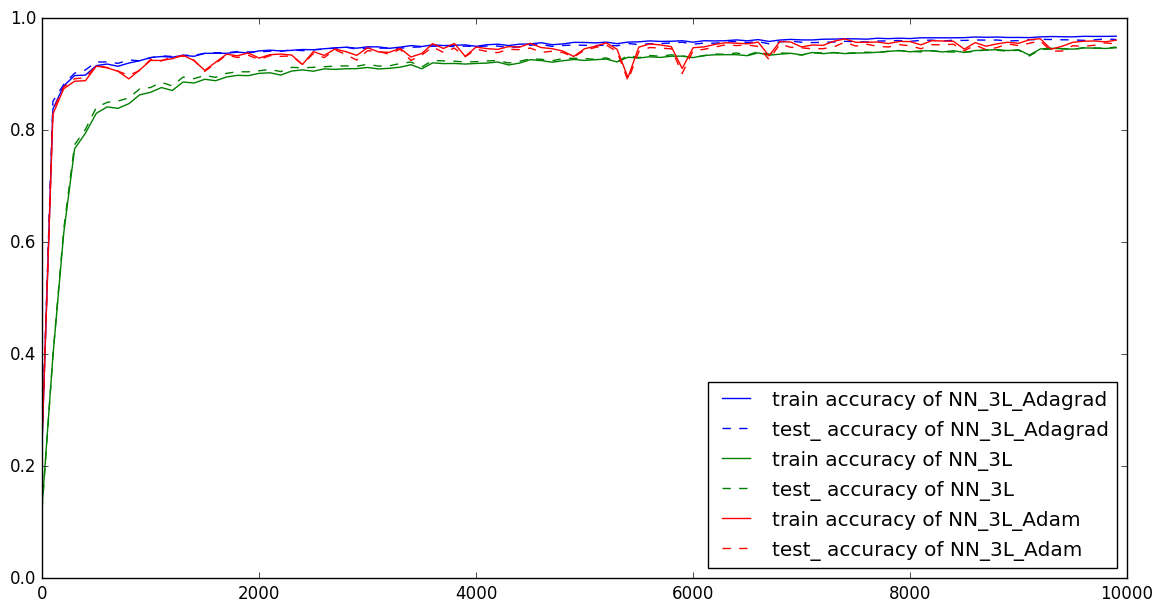

In [115]:
plt.figure(figsize=(14,7),facecolor="w")
plt.style.use('classic')
plt.ylim(0,1)
for (key1, _dict), color in zip(cost_dict.items(), ["blue","green","red"]):
    print(key1)
    for key2, style in zip(["train_cost_list","test_cost_list"],["-","--"]):
        y_plt = _dict[key2]
        plt.plot(np.array(range(len(y_plt)))*100,y_plt,style,c=color,label=key2[:5]+" accuracy of "+key1)
plt.legend(loc="lower right")
plt.show()

## 6. ノイズによる学習効果/性能の変化

In [14]:
def get_X_noised(X_test,d):
    np.random.seed(1)
    rand_mask = np.random.rand(X_test.shape[0],X_test.shape[1])>d
    rand_noise =  np.random.rand(X_test.shape[0],X_test.shape[1])
    X_test_noise = X_test*rand_mask + (1-rand_mask)*rand_noise
    return X_test_noise

25.0%のノイズののった 3


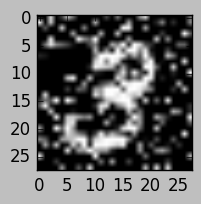

In [23]:
d=0.25
index = 1
plt.figure(figsize=(2,2))
train_X_show = (get_X_noised(X_train[:,index].reshape(28, 28),d)*255).astype("uint8")
plt.imshow(train_X_show, cmap='gray')
print(str(d*100)+"%のノイズののった", int( sum( np.array(range(10))*Y_train[:,index] ) ) )

### 3層、バッチ、ノイズ(1%,5%,10%,25%)

In [100]:
for d in [0.01, 0.05, 0.10, 0.25]:
    print(d*100,"% noised training data")
    arg_dict = {
        "X_train":get_X_noised(X_train,d)
        ,"Ada_grad":True
        ,"learning_rate":0.01
        }
    np.random.seed(1)
    Layer_dims = [784, 128, 32, 10]
    NN = NeuralNetwork(Layer_dims)
    NN = train_NN(NN,**arg_dict)
    NN_models["NN_3L_Adagrad_noise_"+str(d)] = NN
    
dump_NN_models(NN_models)

1.0 % noised training data
#epoch	cost		train_Accuracy	test_Accuracy
  1000	0.2649		0.923272727273		0.9273
  2000	0.21765		0.938072727273		0.9358
  3000	0.188		0.945872727273		0.9447
  4000	0.18436		0.946381818182		0.9452
  5000	0.15798		0.954545454545		0.9526
  6000	0.15086		0.955		0.9508
  7000	0.13684		0.960490909091		0.9558
  8000	0.12932		0.962781818182		0.9573
  9000	0.12085		0.965727272727		0.9607
  10000	0.11624		0.966672727273		0.9603
5.0 % noised training data
#epoch	cost		train_Accuracy	test_Accuracy
  1000	0.28334		0.916254545455		0.9229
  2000	0.2334		0.933381818182		0.9333
  3000	0.2037		0.941836363636		0.94
  4000	0.18762		0.9464		0.9459
  5000	0.16721		0.952490909091		0.9481
  6000	0.16112		0.953163636364		0.9469
  7000	0.14868		0.957054545455		0.95
  8000	0.13767		0.960836363636		0.953
  9000	0.12765		0.963781818182		0.9555
  10000	0.12436		0.964163636364		0.9553
10.0 % noised training data
#epoch	cost		train_Accuracy	test_Accuracy
  1000	0.31268		0.906672727273		0.910

### 3層ニューラルネットの精度の落ち方

In [101]:
NN = NN_models["NN_3L_Adagrad"]
print("通常の正解率：",1-np.abs(Y_test  - Y_test *np.eye(10)[[NN.predict(X_test).argmax(axis=0)]].T).sum(axis=0).mean())
for d in [0.01, 0.02, 0.05, 0.10, 0.15, 0.20, 0.25, 0.50, 0.75, 0.90, 1.0]:
    print(str(d*100)+"%ノイズ時の正解率："
          ,1-np.abs(Y_test  - Y_test *np.eye(10)[[NN.predict(get_X_noised(X_test,d)).argmax(axis=0)]].T).sum(axis=0).mean()
          )

通常の正解率： 0.9613
1.0%ノイズ時の正解率： 0.9604
2.0%ノイズ時の正解率： 0.9586
5.0%ノイズ時の正解率： 0.9493
10.0%ノイズ時の正解率： 0.8966
15.0%ノイズ時の正解率： 0.7817
20.0%ノイズ時の正解率： 0.6447
25.0%ノイズ時の正解率： 0.563
50.0%ノイズ時の正解率： 0.2386
75.0%ノイズ時の正解率： 0.1354
90.0%ノイズ時の正解率： 0.1113
100.0%ノイズ時の正解率： 0.1013


In [15]:
for d1 in [0.01, 0.05, 0.10, 0.25]:
    print("◇訓練データが",str(d1*100)+"%のノイズを含むとき")
    NN = NN_models["NN_3L_Adagrad_noise_"+str(d1)]
    print("通常の正解率：",1-np.abs(Y_test  - Y_test *np.eye(10)[[NN.predict(X_test).argmax(axis=0)]].T).sum(axis=0).mean())
    for d2 in [0.01, 0.02, 0.05, 0.10, 0.15, 0.20, 0.25, 0.50, 0.75, 0.90, 1.0]:
        print(str(d2*100)+"%ノイズ時の正解率："
              ,1-np.abs(Y_test  - Y_test *np.eye(10)[[NN.predict(get_X_noised(X_test,d2)).argmax(axis=0)]].T).sum(axis=0).mean()
              )
    

◇訓練データが 1.0%のノイズを含むとき
通常の正解率： 0.8952
1.0%ノイズ時の正解率： 0.8945
2.0%ノイズ時の正解率： 0.8942
5.0%ノイズ時の正解率： 0.8944
10.0%ノイズ時の正解率： 0.8885
15.0%ノイズ時の正解率： 0.8835
20.0%ノイズ時の正解率： 0.8712
25.0%ノイズ時の正解率： 0.8489
50.0%ノイズ時の正解率： 0.5893
75.0%ノイズ時の正解率： 0.3334
90.0%ノイズ時の正解率： 0.1992
100.0%ノイズ時の正解率： 0.096
◇訓練データが 5.0%のノイズを含むとき
通常の正解率： 0.9553
1.0%ノイズ時の正解率： 0.9549
2.0%ノイズ時の正解率： 0.9545
5.0%ノイズ時の正解率： 0.9528
10.0%ノイズ時の正解率： 0.9427
15.0%ノイズ時の正解率： 0.9259
20.0%ノイズ時の正解率： 0.8892
25.0%ノイズ時の正解率： 0.8259
50.0%ノイズ時の正解率： 0.3729
75.0%ノイズ時の正解率： 0.1651
90.0%ノイズ時の正解率： 0.1107
100.0%ノイズ時の正解率： 0.0908
◇訓練データが 10.0%のノイズを含むとき
通常の正解率： 0.9506
1.0%ノイズ時の正解率： 0.951
2.0%ノイズ時の正解率： 0.9503
5.0%ノイズ時の正解率： 0.949
10.0%ノイズ時の正解率： 0.9439
15.0%ノイズ時の正解率： 0.9351
20.0%ノイズ時の正解率： 0.9167
25.0%ノイズ時の正解率： 0.8844
50.0%ノイズ時の正解率： 0.4623
75.0%ノイズ時の正解率： 0.1663
90.0%ノイズ時の正解率： 0.0955
100.0%ノイズ時の正解率： 0.0892
◇訓練データが 25.0%のノイズを含むとき
通常の正解率： 0.9293
1.0%ノイズ時の正解率： 0.9296
2.0%ノイズ時の正解率： 0.9286
5.0%ノイズ時の正解率： 0.9303
10.0%ノイズ時の正解率： 0.9293
15.0%ノイズ時の正解率： 0.9213
20.0%ノイズ時の正解率： 0.9165
25.0

In [16]:
NN = NN_models['NN_3L_Adagrad_Dropout_0.7']
print("通常の正解率：",1-np.abs(Y_test  - Y_test *np.eye(10)[[NN.predict(X_test).argmax(axis=0)]].T).sum(axis=0).mean())
for d in [0.01, 0.02, 0.05, 0.10, 0.15, 0.20, 0.25, 0.50, 0.75, 0.90, 1.0]:
    print(str(d*100)+"%ノイズ時の正解率："
          ,1-np.abs(Y_test  - Y_test *np.eye(10)[[NN.predict(get_X_noised(X_test,d)).argmax(axis=0)]].T).sum(axis=0).mean()
          )

通常の正解率： 0.9213
1.0%ノイズ時の正解率： 0.9211
2.0%ノイズ時の正解率： 0.9186
5.0%ノイズ時の正解率： 0.913
10.0%ノイズ時の正解率： 0.89
15.0%ノイズ時の正解率： 0.8415
20.0%ノイズ時の正解率： 0.7543
25.0%ノイズ時の正解率： 0.653
50.0%ノイズ時の正解率： 0.2749
75.0%ノイズ時の正解率： 0.1338
90.0%ノイズ時の正解率： 0.1062
100.0%ノイズ時の正解率： 0.1018


In [17]:
NN = NN_models['NN_2L_Adagrad_hidden_unit_10']
print("通常の正解率：",1-np.abs(Y_test  - Y_test *np.eye(10)[[NN.predict(X_test).argmax(axis=0)]].T).sum(axis=0).mean())
for d in [0.01, 0.02, 0.05, 0.10, 0.15, 0.20, 0.25, 0.50, 0.75, 0.90, 1.0]:
    print(str(d*100)+"%ノイズ時の正解率："
          ,1-np.abs(Y_test  - Y_test *np.eye(10)[[NN.predict(get_X_noised(X_test,d)).argmax(axis=0)]].T).sum(axis=0).mean()
          )

通常の正解率： 0.9161
1.0%ノイズ時の正解率： 0.9151
2.0%ノイズ時の正解率： 0.9129
5.0%ノイズ時の正解率： 0.898
10.0%ノイズ時の正解率： 0.832
15.0%ノイズ時の正解率： 0.7063
20.0%ノイズ時の正解率： 0.5667
25.0%ノイズ時の正解率： 0.4602
50.0%ノイズ時の正解率： 0.1499
75.0%ノイズ時の正解率： 0.0897
90.0%ノイズ時の正解率： 0.0892
100.0%ノイズ時の正解率： 0.0892


In [18]:
NN = NN_models['NN_3L_Adagrad_Dropout_0.7']
print("通常の正解率：",1-np.abs(Y_test  - Y_test *np.eye(10)[[NN.predict(X_test).argmax(axis=0)]].T).sum(axis=0).mean())
for d in [0.01, 0.02, 0.05, 0.10, 0.15, 0.20, 0.25, 0.50, 0.75, 0.90, 1.0]:
    print(str(d*100)+"%ノイズ時の正解率："
          ,1-np.abs(Y_test  - Y_test *np.eye(10)[[NN.predict(get_X_noised(X_test,d)).argmax(axis=0)]].T).sum(axis=0).mean()
          )

通常の正解率： 0.9213
1.0%ノイズ時の正解率： 0.9211
2.0%ノイズ時の正解率： 0.9186
5.0%ノイズ時の正解率： 0.913
10.0%ノイズ時の正解率： 0.89
15.0%ノイズ時の正解率： 0.8415
20.0%ノイズ時の正解率： 0.7543
25.0%ノイズ時の正解率： 0.653
50.0%ノイズ時の正解率： 0.2749
75.0%ノイズ時の正解率： 0.1338
90.0%ノイズ時の正解率： 0.1062
100.0%ノイズ時の正解率： 0.1018


In [19]:
NN = NN_models['NN_3L_Adagrad_L2_0.7']
print("通常の正解率：",1-np.abs(Y_test  - Y_test *np.eye(10)[[NN.predict(X_test).argmax(axis=0)]].T).sum(axis=0).mean())
for d in [0.01, 0.02, 0.05, 0.10, 0.15, 0.20, 0.25, 0.50, 0.75, 0.90, 1.0]:
    print(str(d*100)+"%ノイズ時の正解率："
          ,1-np.abs(Y_test  - Y_test *np.eye(10)[[NN.predict(get_X_noised(X_test,d)).argmax(axis=0)]].T).sum(axis=0).mean()
          )

通常の正解率： 0.8843
1.0%ノイズ時の正解率： 0.8848
2.0%ノイズ時の正解率： 0.8839
5.0%ノイズ時の正解率： 0.881
10.0%ノイズ時の正解率： 0.8728
15.0%ノイズ時の正解率： 0.86
20.0%ノイズ時の正解率： 0.8424
25.0%ノイズ時の正解率： 0.8097
50.0%ノイズ時の正解率： 0.5247
75.0%ノイズ時の正解率： 0.3049
90.0%ノイズ時の正解率： 0.1946
100.0%ノイズ時の正解率： 0.1026


## 7. ニューロン数の変更/多層化

### 7. 1. 中間層のニューロン数を変えてみるモデル

In [16]:
for n_hidden_units in [1,2,4,10,32,128,512,2048]:
    print("n_hidden_units:",n_hidden_units)
    np.random.seed(1)
    Layer_dims = [784, n_hidden_units,10]
    NN = NeuralNetwork(Layer_dims)
    NN = train_NN(NN, Ada_grad=True)
    NN_models["NN_2L_Adagrad_hidden_unit_"+str(n_hidden_units)]=NN
dump_NN_models(NN_models)

n_hidden_units: 1
#epoch	cost		train_Accuracy	test_Accuracy
  1000	2.02073		0.186945454545		0.1813
  2000	1.99267		0.191945454545		0.1859
  3000	1.97235		0.257181818182		0.2535
  4000	1.95451		0.251		0.2457
  5000	1.95026		0.252436363636		0.247
  6000	1.93933		0.252727272727		0.2467
  7000	1.92921		0.250490909091		0.2434
  8000	1.91853		0.244109090909		0.2364
  9000	1.91591		0.245418181818		0.2379
  10000	1.90667		0.219909090909		0.2182
n_hidden_units: 2
#epoch	cost		train_Accuracy	test_Accuracy
  1000	1.78951		0.300109090909		0.2994
  2000	1.73444		0.303490909091		0.3026
  3000	1.70547		0.3244		0.3204
  4000	1.68658		0.348072727273		0.3461
  5000	1.65541		0.362527272727		0.364
  6000	1.62567		0.4022		0.4064
  7000	1.58943		0.431872727273		0.4389
  8000	1.55975		0.453036363636		0.4591
  9000	1.52769		0.473672727273		0.4805
  10000	1.49632		0.484509090909		0.4906
n_hidden_units: 4
#epoch	cost		train_Accuracy	test_Accuracy
  1000	1.47151		0.478145454545		0.4842
  2000	1.28492		0.56914545

### 7.2. 層を増やしてみるモデル(64ユニットの層を追加)

In [12]:
for n_Layer in [1,2,3,4,5,6,7]:
    print("{} Layer NN".format(n_Layer))
    np.random.seed(1)
    Layer_dims = [784] + [64]*(n_Layer-1)+ [10]
    NN = NeuralNetwork(Layer_dims)
    NN = train_NN(NN, Ada_grad=True)
    NN_models["NN_{}L_Adagrad_hidden_64".format(n_Layer)]=NN
dump_NN_models(NN_models)

1 Layer NN
#epoch	cost		train_Accuracy	test_Accuracy
  1000	0.45134		0.881654545455		0.8905
  2000	0.3993		0.892890909091		0.9019
  3000	0.37649		0.898218181818		0.9056
  4000	0.36266		0.902218181818		0.908
  5000	0.35333		0.904072727273		0.9095
  6000	0.34562		0.905836363636		0.9114
  7000	0.34007		0.906327272727		0.9119
  8000	0.33606		0.907545454545		0.9138
  9000	0.33049		0.908327272727		0.9136
  10000	0.32739		0.910454545455		0.9138
2 Layer NN
#epoch	cost		train_Accuracy	test_Accuracy
  1000	0.29222		0.915872727273		0.9223
  2000	0.24862		0.930527272727		0.9317
  3000	0.22927		0.935890909091		0.9362
  4000	0.21446		0.939345454545		0.9397
  5000	0.20225		0.943345454545		0.9429
  6000	0.19289		0.946		0.9433
  7000	0.18526		0.947181818182		0.9451
  8000	0.17851		0.949018181818		0.9459
  9000	0.17331		0.950672727273		0.9468
  10000	0.16845		0.952309090909		0.9486
3 Layer NN
#epoch	cost		train_Accuracy	test_Accuracy
  1000	0.31519		0.911781818182		0.9183
  2000	0.25427		0.927981818182	

## 8. 最適刺激の計算

### 概要

$\min_\limits{X^{opt}}{
    E(W,X^{opt},Y^{opt})
    -\lambda \sum_\limits{i}\left\{ \log X^{opt}_i + \log(1-X^{opt}_i) \right\}
     + \mu   \sum_\limits{i}\left | X^{opt}_i-0.01\right| 
}$<br>
として、$X^{opt}_i\in [0,1] \ \ (\forall i)$ が満たされるようにした.<br>
※きれいな画像が出力されるように適当に調整して、$\ \lambda=0.001, \mu=0.02$ とした.<br>
※
\begin{eqnarray}
X^{opt}&\in& [0,1]^{28\times 28}
\\
Y^{opt}&\in&
\left\{
    \
    \left[\begin{array}{rr}
        1 \\ 0 \\ \vdots \\ 0
    \end{array}\right]
    ,\
    \left[\begin{array}{rr}
        0 \\ 1 \\ \vdots \\ 0
    \end{array}\right]
    ,\
    \cdots
    ,\
    \left[\begin{array}{rr}
        0 \\ 0 \\ \vdots \\ 1
    \end{array}\right]
    \
\right\}
\subset\{0,1\}^{10}
\end{eqnarray}

In [191]:
def print_optimal_input(NN,lambd=1e-3, mu=0, n_iter=2000):
    X_opt_dict = {}
    for index_opt in [0,1,2,3,4,5,6,7,8,9]:
        np.random.seed(1)
        Y_opt = np.eye(10)[index_opt].reshape(-1,1)
        X_opt = np.zeros(28*28).reshape(-1,1) + 1/10
        learning_rate = 0.01
        for i in range(n_iter):
            NN.forward_prop(X_opt,keep_prob=1)
            Y_opt_pred = NN.Layers[NN.n_Layers-1].X_out
            dY_opt_pred = NN.compute_dY_pred(Y_opt,Y_opt_pred)
            NN.backward_prop(dY_opt_pred)
            dE_dX_opt = NN.Layers[0].dX_in
            dL_dX_opt = (1/(1-X_opt) - 1/X_opt)*lambd + ((X_opt>0.01) + (X_opt<0.01))*mu
            dX_opt = dE_dX_opt + dL_dX_opt
            X_opt = X_opt - learning_rate*dX_opt
            if i==(n_iter-1):
                pass 
                #print("for index",index_opt,":",NN.compute_cost(X_opt,Y_opt))
                #print(X_opt.max())
        X_opt_dict["X_opt_"+str(index_opt)] = X_opt
    plt.figure(figsize=(10,4))
    for index_opt in [0,1,2,3,4,5,6,7,8,9]:
        X_opt = X_opt_dict["X_opt_"+str(index_opt)]
        X_opt_show = (X_opt*255).reshape(28, 28).astype("uint8")
        plt.subplot(2,5,index_opt+1)
        plt.imshow(X_opt_show, cmap='gray')

### 番号ごとの画像の平均

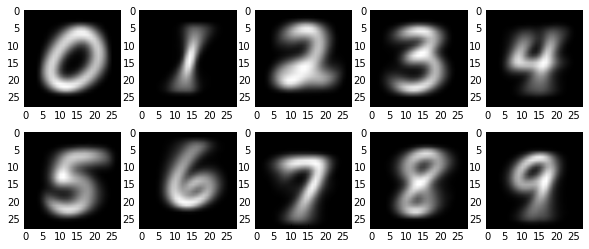

In [19]:
plt.figure(figsize=(10,4))
for index_print in [0,1,2,3,4,5,6,7,8,9]:
    test_X_show = (X_train[:,Y_train[index_print,:]==1].mean(axis=1).reshape(28, 28)*255).astype("uint8")
    plt.subplot(2,5,index_print+1)
    plt.imshow(test_X_show, cmap='gray')

### 3層のニューラルネットの最適刺激

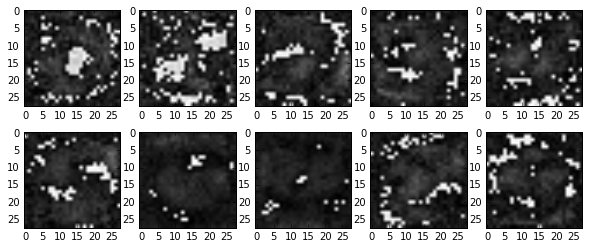

In [198]:
print_optimal_input(NN_models['NN_3L_Adagrad'], lambd=0, n_iter=2000)

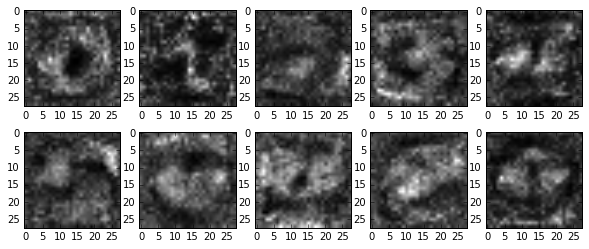

In [197]:
print_optimal_input(NN_models['NN_3L_Adagrad'], n_iter=2000 )

### 3層のニューラルネットの最適刺激(L2正則化)

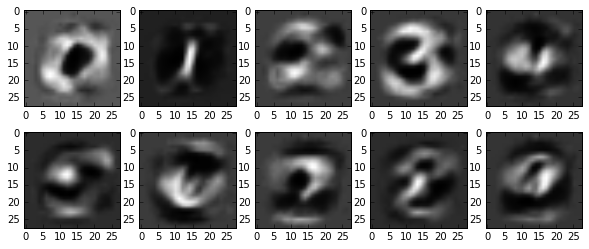

In [200]:
print_optimal_input(NN_models['NN_3L_Adagrad_L2_0.7'], n_iter=600)

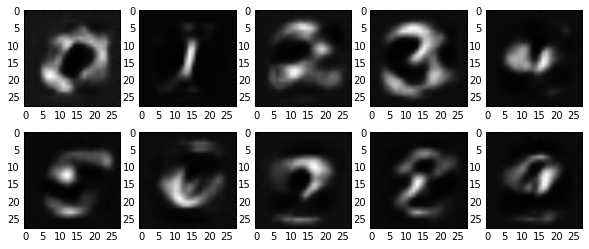

In [206]:
# スパース化
print_optimal_input(NN_models['NN_3L_Adagrad_L2_0.7'],mu=0.03 , n_iter=600)